In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Dataset init.
        :param data_dir: Dataset root directory ('train''test''val')
        :param transform: Data preprocessing
        """
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if not os.path.exists(cls_dir):
                continue
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    samples.append((img_path, self.class_to_idx[cls]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = ChestXrayDataset(
    data_dir='/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train', transform=train_transform)
val_dataset = ChestXrayDataset(
    data_dir='/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val', transform=test_transform)
test_dataset = ChestXrayDataset(
    data_dir='/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test', transform=test_transform)

In [7]:
train_batch_size = 128
test_val_batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=train_batch_size,
                          shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=test_val_batch_size,
                        shuffle=False, drop_last=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=test_val_batch_size,
                         shuffle=False, drop_last=False, num_workers=4)

In [8]:
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")  # 打印图像张量形状
    print(f"Batch labels: {labels}")  # 打印标签
    break

Batch images shape: torch.Size([128, 3, 224, 224])
Batch labels: tensor([2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 3, 1, 2, 2, 2, 1, 2, 1, 1, 3, 1, 2, 2, 2,
        2, 2, 0, 1, 0, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2,
        3, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 3, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2,
        1, 1, 2, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 3, 2,
        1, 2, 2, 2, 2, 0, 2, 2])


In [9]:
def get_net(device):
    model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    num_classes = 4
    in_features = model.heads.head.in_features
    
    model.heads.head = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    return model.to(device)

model = get_net(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 222MB/s]


In [10]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [11]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [12]:
def plot_training_history(history, epoch, epochs):
   
    clear_output(wait=True)
    plt.figure(figsize=(12, 4))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Epoch {epoch+1}/{epochs}')
    plt.legend()
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Epoch {epoch+1}/{epochs}')
    plt.legend()
    
    plt.tight_layout()
    # plt.savefig(f'/kaggle/working/epoch_{epoch+1}.png')
    plt.show()

In [13]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, device, epochs=10, patience=5):
    best_acc = 0.0
    best_loss = 1e4
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_without_improvement = 0  # 记录验证集性能无提升的epoch数
    
    for epoch in range(epochs):
        # 训练和验证
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        
        # 记录历史数据
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 保存最佳模型
        if epoch >= 10 and val_acc >= best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            torch.save(model.state_dict(), f'/kaggle/working/model_epoch{epoch+1}.pth')

        # 早停
        if train_loss <= best_loss:
            best_loss = train_loss
            epochs_without_improvement = 0  # 重置计数器
        else:
            epochs_without_improvement += 1  # 验证集性能未提升
        
        # 动态绘制训练曲线
        plot_training_history(history, epoch, epochs)
        
        # 打印进度
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Best Val Acc: {best_acc:.4f}')
        print(f'Epochs without improvement: {epochs_without_improvement}/{patience}\n')
        
        # 早停检查
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}!')
            break
        
        time.sleep(0.1)
    
    print(f'Best Val Acc: {best_acc:.4f}')
    return history

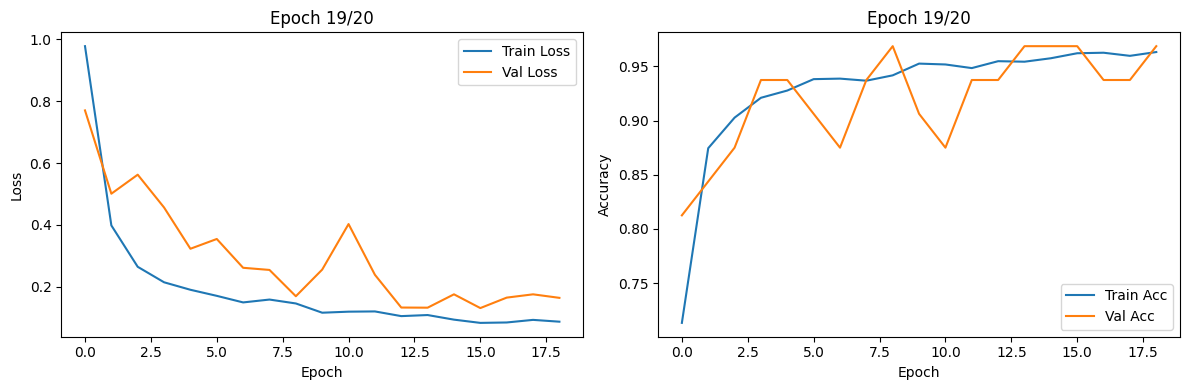

Epoch 19/20
Train Loss: 0.0872 Acc: 0.9633
Val Loss: 0.1643 Acc: 0.9688
Best Val Acc: 0.9688
Epochs without improvement: 3/3

Early stopping triggered at epoch 19!
Best Val Acc: 0.9688


In [14]:
optimizer = torch.optim.AdamW(
    (param for param in model.parameters() if param.requires_grad),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5),  # 前5个epoch预热
        torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)  # 余下15个epoch使用余弦退火
    ],
    milestones=[5]  # 第5个epoch后切换
)

class_weights = torch.tensor([3.51, 1.17, 0.41, 2.43]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    device,
    epochs=20,
    patience=3,
)

In [15]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_loss / total
    test_acc = correct / total
    
    return test_loss, test_acc, all_preds, all_labels

In [16]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth', weights_only=True))
model.eval()

# evaluate
test_loss, test_acc, all_preds, all_labels = test_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Test Loss: 0.3225
Test Accuracy: 0.8872


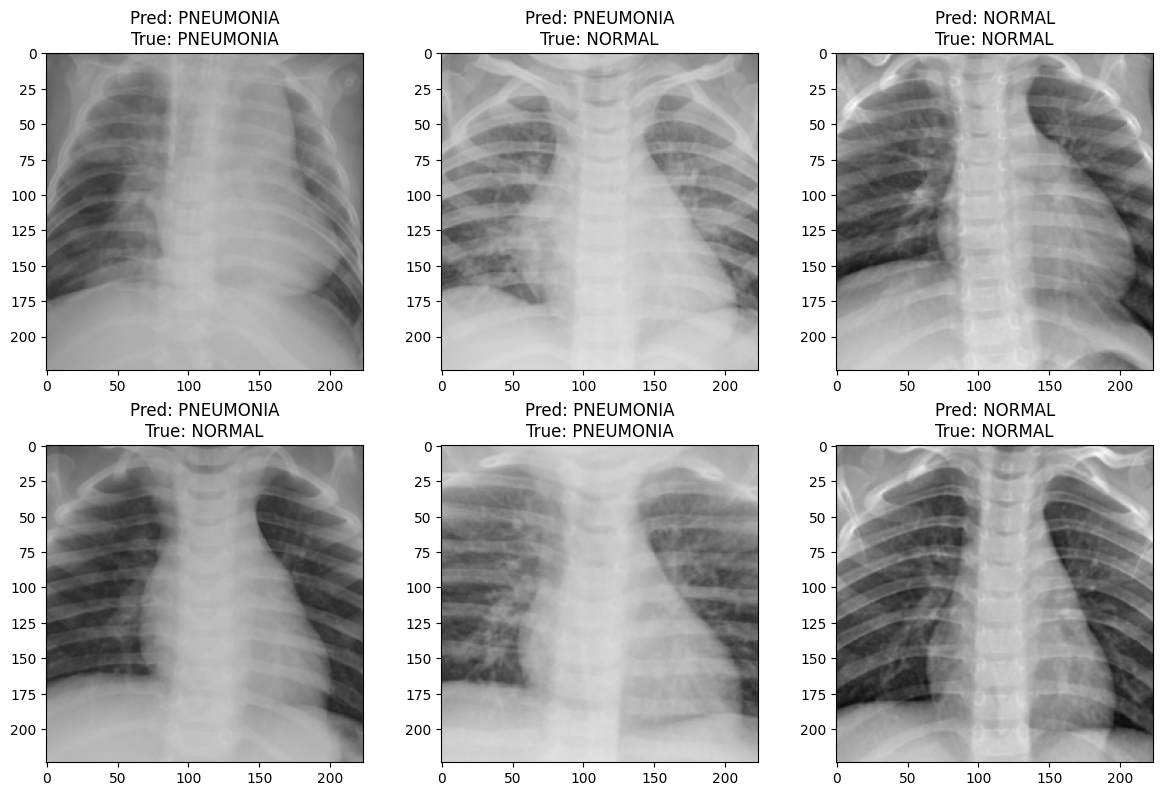

In [17]:
def unnormalize(img, mean, std):
    img = img.clone().cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img


# 归一化参数
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# 随机采样num_images个测试样本
num_images = 6
indices = np.random.choice(len(test_dataset), num_images, replace=False)
samples = [test_dataset[i] for i in indices]
images, labels = zip(*samples)
images = torch.stack(images)  # shape: [num_images, C, H, W]
labels = torch.tensor(labels)

# 模型预测
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']

# 绘制预测结果
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i in range(num_images):
    ax = axes[i]
    # 对每张图像进行反归一化处理
    img = unnormalize(images[i], mean, std)
    ax.imshow(img)
    ax.set_title(f"Pred: {target_names[preds[i].item()]}\nTrue: {target_names[labels[i].item()]}")
    ax.tick_params(axis='both', which='both', labelsize=10)
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

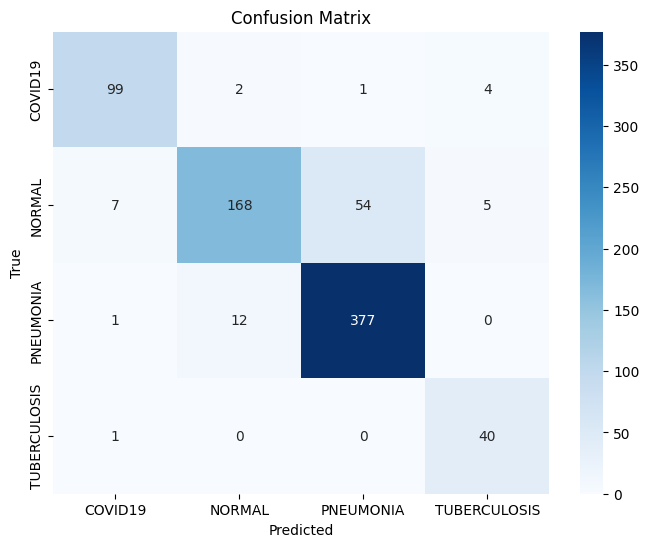

In [19]:
cm = confusion_matrix(all_labels, all_preds)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS'], 
            yticklabels=['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
print(classification_report(
    all_labels,
    all_preds,
    target_names=['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
))

              precision    recall  f1-score   support

     COVID19       0.92      0.93      0.93       106
      NORMAL       0.92      0.72      0.81       234
   PNEUMONIA       0.87      0.97      0.92       390
TUBERCULOSIS       0.82      0.98      0.89        41

    accuracy                           0.89       771
   macro avg       0.88      0.90      0.88       771
weighted avg       0.89      0.89      0.88       771

